In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import importlib

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=500, formatter={'float': '{:.1e}'.format})

This notebook studies the qubit proposed by KIT, but substituting the central inductor for a Josephson junction. It's lumped element model is:
<img src='Other/Single qubit 4 nodes CC coupled to ground.jpg' width='500'>


In [2]:
# Fundamental constants
h    = 6.626e-34
GHz = 1e9
e0   = 1.602e-19
Φ_0 = h/(2*e0)

In [3]:
# Circuit parameters
Csh = 15
C   = 15
Cg  = 10
CJ  = 3
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0
EJ_r = 2.5
l = Lq*(Lq+4*Lr) - 4*Δ**2

## Original qubit

In [4]:
# Initialize loop(s)
loop = sq.Loop(0.5)

# Circuit components
C_01 = sq.Capacitor(C,       'fF')
C_02 = sq.Capacitor(C,       'fF')
C_12 = sq.Capacitor(CJ+Csh,  'fF')
L_03 = sq.Inductor(Lr,       'nH')
L_31 = sq.Inductor(Lq/2 - Δ, 'nH',  loops=[loop])
L_23 = sq.Inductor(Lq/2 + Δ, 'nH',  loops=[loop])
JJ_12= sq.Junction(EJ,       'GHz', loops=[loop])

elements = {
    # Without ground node
    (0, 3): [L_03],
    (0, 1): [C_01],
    (0, 2): [C_02],
    (3, 1): [L_31],
    (1, 2): [C_12, JJ_12],
    (2, 3): [L_23],
}
# Create the circuits
qubit = sq.Circuit(elements)
qubit.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
sq_ext.print_flux_transformation(qubit)

Φ_1 = [ 0.00  0.00  1.00]
Φ_2 = [ 1.00  0.98  0.61]
Φ_3 = [-0.93  1.00  0.02]


## Modified qubit

In [13]:
EJ_r = 5


# Initialize loop(s)
loop_mod = sq.Loop(0.5)

# Circuit components
C_01 = sq.Capacitor(C,       'fF')
C_02 = sq.Capacitor(C,       'fF')
C_12 = sq.Capacitor(CJ+Csh,  'fF')
L_31 = sq.Inductor(Lq/2 - Δ, 'nH',  loops=[loop_mod])
L_23 = sq.Inductor(Lq/2 + Δ, 'nH',  loops=[loop_mod])
JJ_12= sq.Junction(EJ,       'GHz', loops=[loop_mod])
JJ_03= sq.Junction(EJ_r,     'GHz')

elements = {
    # Without ground node
    (0, 3): [JJ_03],
    (0, 1): [C_01],
    (0, 2): [C_02],
    (3, 1): [L_31],
    (1, 2): [C_12, JJ_12],
    (2, 3): [L_23],
}
# Create the circuits
qubit_mod = sq.Circuit(elements)
qubit_mod.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [75]:
sq_ext.print_flux_transformation(qubit_mod)

Φ_1 = [0.00+0.00j -0.00+0.00j -0.00+0.00j 1.00+0.00j]
Φ_2 = [0.00-0.00j -1.00+0.00j 1.00-0.00j -0.01-0.00j]
Φ_3 = [0.95+0.02j -1.00+0.02j -1.00+0.02j -1.00+0.02j]
Φ_4 = [1.00-0.01j 1.00-0.01j 1.00-0.01j 1.00-0.01j]


In [76]:
sq_ext.truncation_convergence(qubit_mod, 4)

KeyboardInterrupt: 

In [53]:
qubit_mod.set_trunc_nums([8, 5, 5])

# spectrum of the qubit
phi = np.linspace(0.5,1,25)
# phi = np.concatenate((np.linspace(0,0.44,50),np.linspace(0.44,0.49,50), np.linspace(0.49,1,50)))
n_eig=8
E_circuit = np.zeros((n_eig, len(phi)))

eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))
for i in range(len(phi)):
    loop_mod.set_flux(phi[i])
    E_circuit[:, i] = qubit_mod.diag(n_eig)[0]

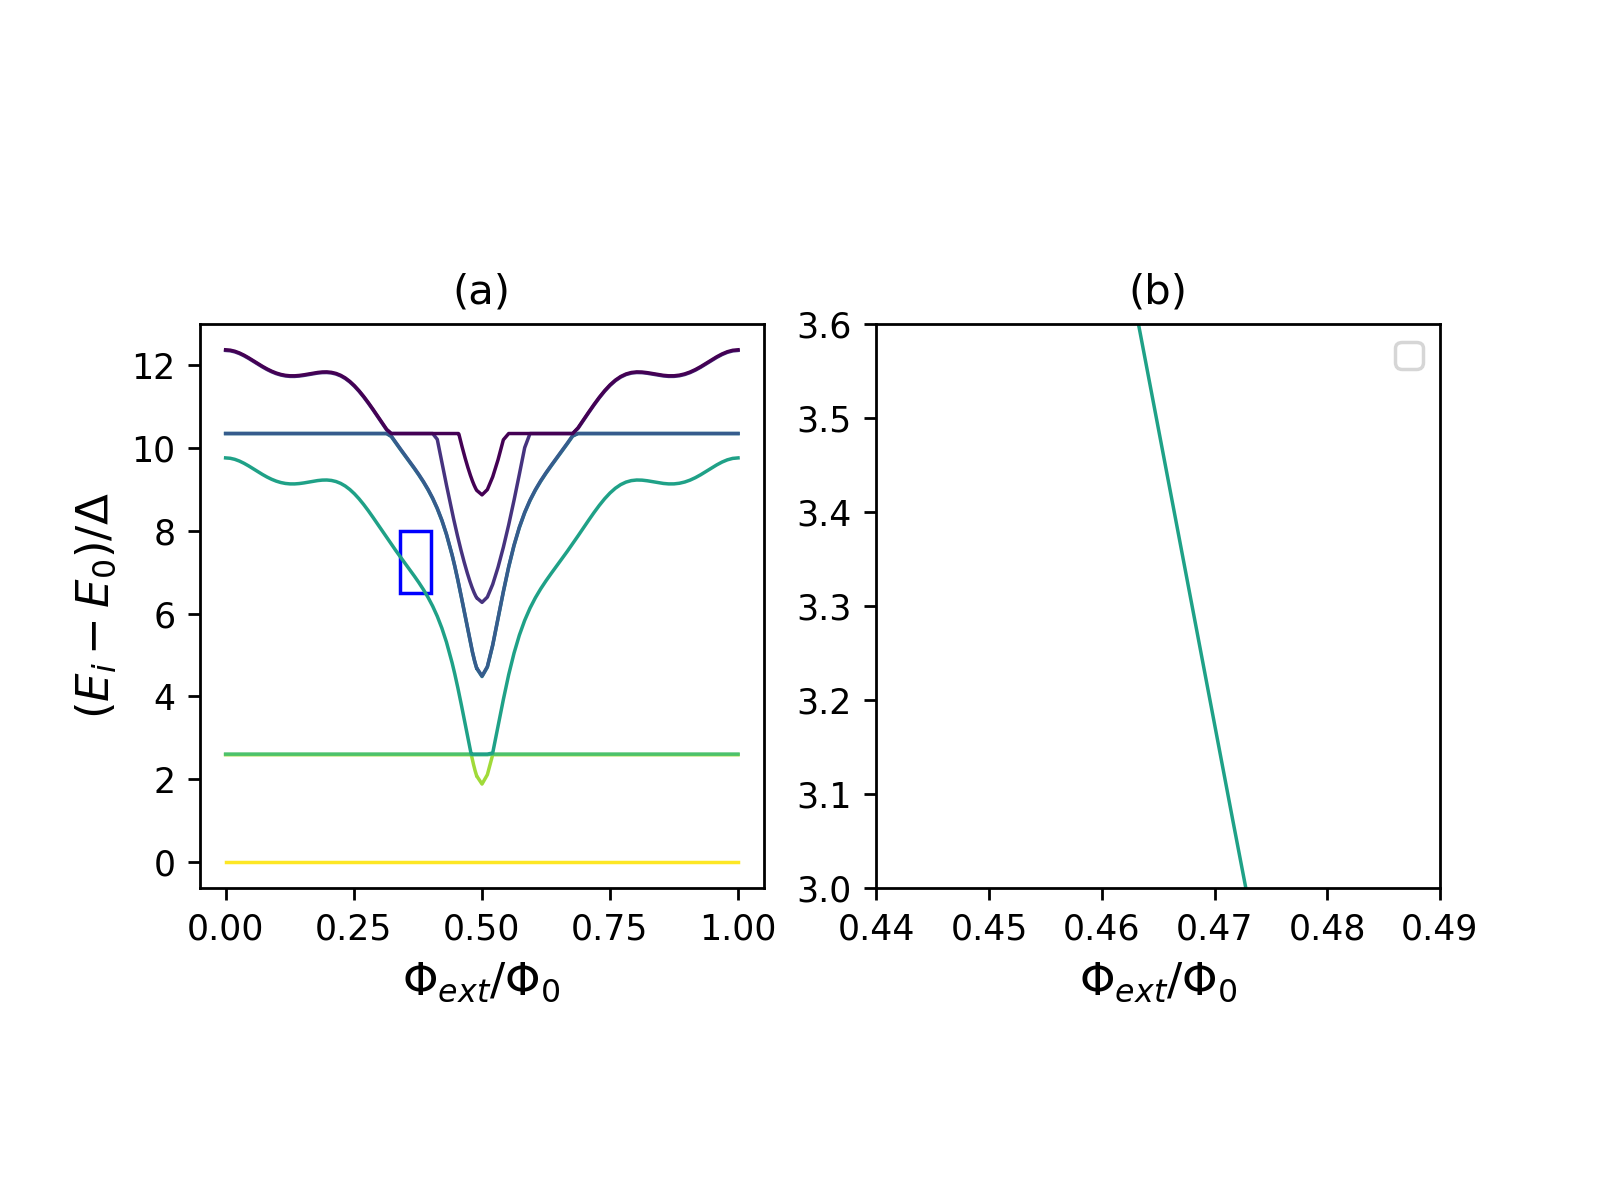

In [54]:
fig, axs = plt.subplots(dpi=250, ncols=2)
for ax in axs:
    for i in range(n_eig):
        ax.plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i], linewidth=1)

    ax.set_box_aspect(1)
    ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
    if ax == axs[0]:
        rect = patches.Rectangle((0.34, 6.5), 0.06, 1.5, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.set_title('(a)')
        ax.set_ylabel(r"$(E_i-E_0)/\Delta$", fontsize=13)
    else:
        ax.set_title('(b)')
        ax.set_xlim(0.44,0.49)
        ax.set_ylim(3,3.6)
        ax.legend()
fig.show()
# figs.export('Spectrum.pdf')